In [ ]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt

# Verbindung zur MongoDB-Datenbank herstellen
client = MongoClient("mongodb://192.168.0.76:27017/")

# Datenbank und Sammlung auswählen
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Daten abrufen
data = list(collection.find())

# Daten in ein Pandas DataFrame umwandeln
df = pd.DataFrame(data)

# Beispielhafte Ausgabe der Daten
print(df.head())


In [ ]:
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

def decode_base64_image(base64_string):
    image_data = base64.b64decode(base64_string.split(',')[1])
    image = Image.open(BytesIO(image_data))
    return image

# Beispielhafte Dekodierung und Anzeige eines Canvas-Bildes
sample_canvas = df['canvases'][0][0]  # Erster Canvas des ersten Dokuments
image = decode_base64_image(sample_canvas)
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
# Alle Canvas-Bilder visualisieren (maximal 5 pro Benutzer)
for index, row in df.iterrows():
    canvases = row['canvases'][:5]  # Maximal 5 Canvas-Bilder pro Benutzer
    for i, canvas in enumerate(canvases):
        image = decode_base64_image(canvas)
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title(f"User: {row['name']} - Canvas {i+1}")
        plt.axis('off')
        plt.show()


In [ ]:
# Beispielhafte Umwandlung von Fingerprint-Hashes in numerische Werte
def hash_to_numeric(hash_str):
    return int(hash_str, 16) % 1000000  # Beispielhafte Umwandlung, um mehr Werte zu erhalten

# Datenpunkte für den Graphen vorbereiten
df['fingerprint_numeric'] = df['fingerprintHash'].apply(hash_to_numeric)

# Scatter-Plot der Fingerprint-Daten
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['fingerprint_numeric'], c='blue', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Fingerprint Numeric Value')
plt.title('Fingerprint Hashes als Datenpunkte')
plt.show()


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import pymongo
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import tensorflow as tf

# GPU-Speicherwachstum aktivieren
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Überprüfen, ob die GPU verfügbar ist
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://192.168.0.76:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    base64_data = base64_string.split(",")[1]
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return np.array(image)

# Funktion zum Abrufen der Canvases
def get_canvases(data):
    return [decode_base64_image(canvas) for canvas in data["canvases"]]

# Benutzername
username = "username_1"

# Positive Beispiele (Canvases des aktuellen Benutzers)
user = collection.find_one({"username": username})
user_canvases = get_canvases(user)
X_positive = np.array(user_canvases)
y_positive = np.ones(len(X_positive))

# Negative Beispiele (Canvases der anderen Benutzer)
X_negative = []
y_negative = []

# Auswahl von maximal 2 anderen Benutzern
other_users = list(collection.find({"username": {"$ne": username}}))
np.random.shuffle(other_users)
selected_users = other_users[:2]

for other_user in selected_users:
    other_user_canvases = get_canvases(other_user)
    X_negative.extend(other_user_canvases)
    y_negative.extend([0] * len(other_user_canvases))

# Zufällig 2500 negative Beispiele auswählen
if len(X_negative) > 2500:
    indices = np.random.choice(len(X_negative), 2500, replace=False)
    X_negative = np.array(X_negative)[indices]
    y_negative = np.array(y_negative)[indices]
else:
    X_negative = np.array(X_negative)
    y_negative = np.array(y_negative)

# Kombinieren der Daten
X = np.concatenate((X_positive, X_negative), axis=0)
y = np.concatenate((y_positive, y_negative), axis=0)

# Aufteilen der Daten in Trainings- und Testsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Streudiagramm der Datenpunkte
plt.figure(figsize=(10, 5))
for i in range(len(y)):
    if y[i] == 1:
        plt.scatter(X[i, 0], X[i, 1], color='green', label='Positive' if i == 0 else "")
    else:
        plt.scatter(X[i, 0], X[i, 1], color='red', label='Negative' if i == 0 else "")
plt.title('Streudiagramm der Datenpunkte')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


Physical devices cannot be modified after being initialized
Num GPUs Available:  1


KeyboardInterrupt: 

In [3]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import pymongo
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import tensorflow as tf

# GPU-Speicherwachstum aktivieren
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://192.168.0.76:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    base64_data = base64_string.split(",")[1]
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return np.array(image)

# Funktion zum Abrufen der Canvases
def get_canvases(data):
    return [decode_base64_image(canvas) for canvas in data["canvases"]]

# Benutzername
username = "username_1"

# Positive Beispiele (Canvases des aktuellen Benutzers)
user = collection.find_one({"username": username})
user_canvases = get_canvases(user)
X_positive = np.array(user_canvases)
y_positive = np.ones(len(X_positive))

# Negative Beispiele (Canvases der anderen Benutzer)
X_negative = []
y_negative = []

# Auswahl von maximal 2 anderen Benutzern
other_users = list(collection.find({"username": {"$ne": username}}))
np.random.shuffle(other_users)
selected_users = other_users[:2]

for other_user in selected_users:
    other_user_canvases = get_canvases(other_user)
    X_negative.extend(other_user_canvases)
    y_negative.extend([0] * len(other_user_canvases))

# Zufällig 2500 negative Beispiele auswählen
if len(X_negative) > 2500:
    indices = np.random.choice(len(X_negative), 2500, replace=False)
    X_negative = np.array(X_negative)[indices]
    y_negative = np.array(y_negative)[indices]
else:
    X_negative = np.array(X_negative)
    y_negative = np.array(y_negative)

# Kombinieren der Daten
X = np.concatenate((X_positive, X_negative), axis=0)
y = np.concatenate((y_positive, y_negative), axis=0)

# Aufteilen der Daten in Trainings- und Testsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


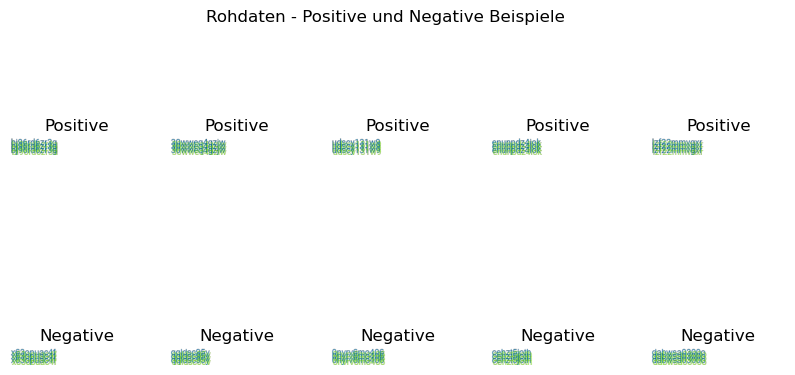

In [4]:
# Beispielhafte Visualisierung der Rohdaten
plt.figure(figsize=(10, 5))

# Positive Beispiele
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_positive[i])
    plt.title('Positive')
    plt.axis('off')

# Negative Beispiele
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_negative[i])
    plt.title('Negative')
    plt.axis('off')

plt.suptitle('Rohdaten - Positive und Negative Beispiele')
plt.show()


In [ ]:
# Daten normalisieren
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

# Beispielhafte Visualisierung der normalisierten Daten
plt.figure(figsize=(10, 5))

# Positive Beispiele
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train_norm[i])
    plt.title('Positive')
    plt.axis('off')

# Negative Beispiele
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_train_norm[len(X_positive) + i])
    plt.title('Negative')
    plt.axis('off')

plt.suptitle('Normalisierte Daten - Positive und Negative Beispiele')
plt.show()


In [ ]:
# Datenpunkte visualisieren
plt.figure(figsize=(10, 5))

# Positive Datenpunkte
for i in range(len(y_train)):
    if y_train[i] == 1:
        plt.scatter(X_train[i].flatten()[0], X_train[i].flatten()[1], color='green', label='Positive' if i == 0 else "")

# Negative Datenpunkte
for i in range(len(y_train)):
    if y_train[i] == 0:
        plt.scatter(X_train[i].flatten()[0], X_train[i].flatten()[1], color='red', label='Negative' if i == 0 else "")

plt.title('Datenpunkte - Positive und Negative Beispiele')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


Epoch 1/50
220/220 [==============================] - 11s 10ms/step - loss: 45.9253 - accuracy: 0.9091 - val_loss: 0.0133 - val_accuracy: 0.9989
Epoch 2/50
220/220 [==============================] - 2s 8ms/step - loss: 0.1043 - accuracy: 0.9952 - val_loss: 0.4121 - val_accuracy: 0.9795
Epoch 3/50
220/220 [==============================] - 2s 7ms/step - loss: 0.2250 - accuracy: 0.9906 - val_loss: 0.0342 - val_accuracy: 0.9966
Epoch 4/50
220/220 [==============================] - 2s 7ms/step - loss: 0.0312 - accuracy: 0.9980 - val_loss: 0.0168 - val_accuracy: 0.9989
Epoch 5/50
220/220 [==============================] - 2s 9ms/step - loss: 0.0400 - accuracy: 0.9972 - val_loss: 1.5814e-08 - val_accuracy: 1.0000
Epoch 6/50
220/220 [==============================] - 2s 8ms/step - loss: 0.0547 - accuracy: 0.9986 - val_loss: 0.0095 - val_accuracy: 0.9977
Epoch 7/50
220/220 [==============================] - 2s 7ms/step - loss: 0.0739 - accuracy: 0.9972 - val_loss: 0.1316 - val_accuracy: 0.9977

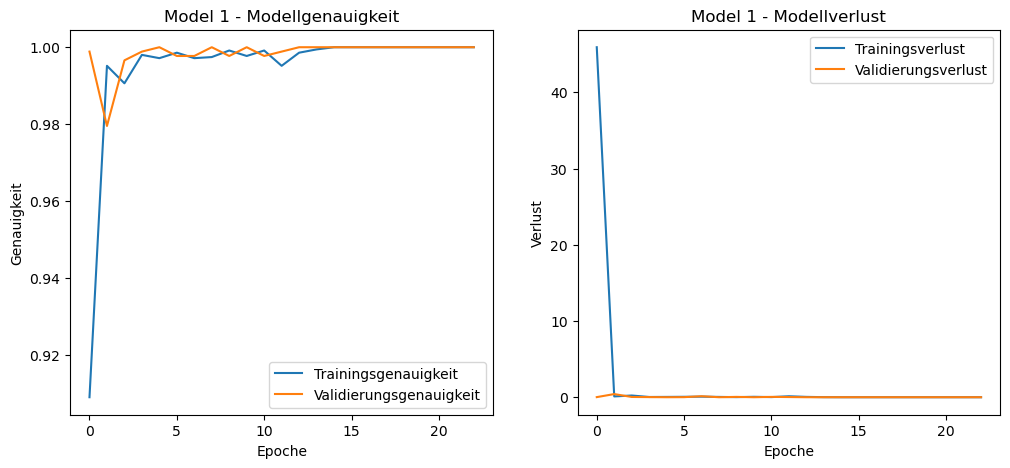

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Modell 1 definieren
def create_model_1(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

input_shape = X_train.shape[1:]
model_1 = create_model_1(input_shape)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_1.h5', save_best_only=True)

# Modell 1 trainieren
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])

# Trainingsverlauf visualisieren
plt.figure(figsize=(12, 5))

# Genauigkeit visualisieren
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history_1.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.title('Model 1 - Modellgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')
plt.legend()

# Verlust visualisieren
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Trainingsverlust')
plt.plot(history_1.history['val_loss'], label='Validierungsverlust')
plt.title('Model 1 - Modellverlust')
plt.xlabel('Epoche')
plt.ylabel('Verlust')
plt.legend()

plt.show()


Epoch 1/50
220/220 [==============================] - 5s 18ms/step - loss: 49.5393 - accuracy: 0.8980 - val_loss: 4.4863e-04 - val_accuracy: 1.0000
Epoch 2/50
220/220 [==============================] - 3s 13ms/step - loss: 0.1007 - accuracy: 0.9929 - val_loss: 0.0160 - val_accuracy: 0.9989
Epoch 3/50
220/220 [==============================] - 3s 14ms/step - loss: 0.0343 - accuracy: 0.9972 - val_loss: 0.1950 - val_accuracy: 0.9875
Epoch 4/50
220/220 [==============================] - 3s 13ms/step - loss: 0.2981 - accuracy: 0.9866 - val_loss: 0.0049 - val_accuracy: 0.9989
Epoch 5/50
220/220 [==============================] - 4s 17ms/step - loss: 0.0522 - accuracy: 0.9963 - val_loss: 4.8389e-23 - val_accuracy: 1.0000
Epoch 6/50
220/220 [==============================] - 3s 13ms/step - loss: 0.0444 - accuracy: 0.9972 - val_loss: 0.0238 - val_accuracy: 0.9989
Epoch 7/50
220/220 [==============================] - 3s 13ms/step - loss: 0.0270 - accuracy: 0.9994 - val_loss: 1.4511e-11 - val_acc

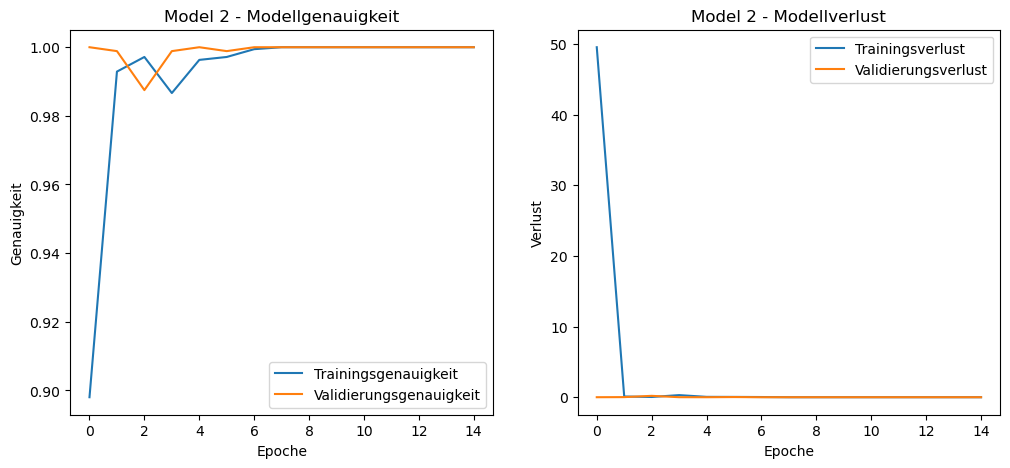

In [6]:
# Modell 2 definieren
def create_model_2(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model_2 = create_model_2(input_shape)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_2.h5', save_best_only=True)

# Modell 2 trainieren
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])

# Trainingsverlauf visualisieren
plt.figure(figsize=(12, 5))

# Genauigkeit visualisieren
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history_2.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.title('Model 2 - Modellgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')
plt.legend()

# Verlust visualisieren
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Trainingsverlust')
plt.plot(history_2.history['val_loss'], label='Validierungsverlust')
plt.title('Model 2 - Modellverlust')
plt.xlabel('Epoche')
plt.ylabel('Verlust')
plt.legend()

plt.show()


Epoch 1/50
220/220 [==============================] - 13s 54ms/step - loss: 104.1342 - accuracy: 0.9173 - val_loss: 0.4377 - val_accuracy: 0.9818
Epoch 2/50
220/220 [==============================] - 12s 53ms/step - loss: 0.1239 - accuracy: 0.9969 - val_loss: 3.9871e-12 - val_accuracy: 1.0000
Epoch 3/50
220/220 [==============================] - 11s 51ms/step - loss: 0.2492 - accuracy: 0.9920 - val_loss: 2.4089e-20 - val_accuracy: 1.0000
Epoch 4/50
220/220 [==============================] - 11s 52ms/step - loss: 0.0382 - accuracy: 0.9986 - val_loss: 3.1281e-24 - val_accuracy: 1.0000
Epoch 5/50
220/220 [==============================] - 8s 35ms/step - loss: 0.0148 - accuracy: 0.9991 - val_loss: 1.4728e-17 - val_accuracy: 1.0000
Epoch 6/50
220/220 [==============================] - 8s 35ms/step - loss: 1.5902e-04 - accuracy: 1.0000 - val_loss: 2.6029e-13 - val_accuracy: 1.0000
Epoch 7/50
220/220 [==============================] - 8s 35ms/step - loss: 2.2713e-22 - accuracy: 1.0000 - val_l

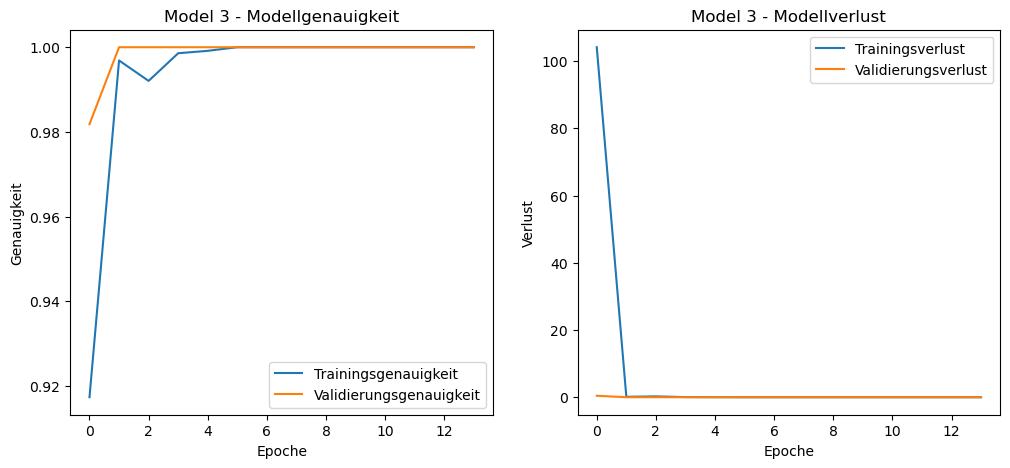

In [7]:
# Modell 3 definieren
def create_model_3(input_shape):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model_3 = create_model_3(input_shape)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_3.h5', save_best_only=True)

# Modell 3 trainieren
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])

# Trainingsverlauf visualisieren
plt.figure(figsize=(12, 5))

# Genauigkeit visualisieren
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history_3.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.title('Model 3 - Modellgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')
plt.legend()

# Verlust visualisieren
plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Trainingsverlust')
plt.plot(history_3.history['val_loss'], label='Validierungsverlust')
plt.title('Model 3 - Modellverlust')
plt.xlabel('Epoche')
plt.ylabel('Verlust')
plt.legend()

plt.show()


28/28 [==============================] - 0s 5ms/step
     Model  Accuracy
0  Model 1  0.502986
1  Model 2  0.502986
2  Model 3  0.502986


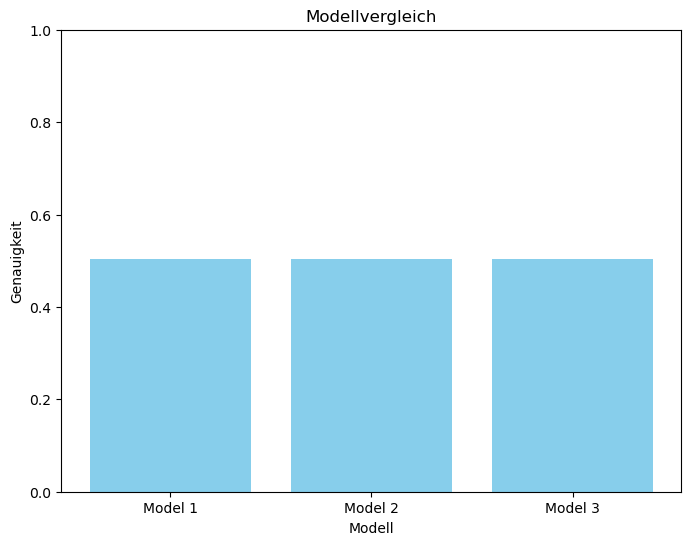

In [11]:
# Ergebnisse in einem DataFrame anzeigen
results = [
    {'Model': 'Model 1', 'Accuracy': np.mean((model_2.predict(X_test) > 0.2).astype(int) == y_test)},
    {'Model': 'Model 2', 'Accuracy': np.mean((model_2.predict(X_test) > 0.5).astype(int) == y_test)},
    {'Model': 'Model 3', 'Accuracy': np.mean((model_3.predict(X_test) > 0.5).astype(int) == y_test)}
]
results_df = pd.DataFrame(results)
print(results_df)

# Ergebnisse visualisieren
plt.figure(figsize=(8, 6))
plt.bar(results_df['Model'], results_df['Accuracy'], color='skyblue')
plt.title('Modellvergleich')
plt.xlabel('Modell')
plt.ylabel('Genauigkeit')
plt.ylim(0, 1)
plt.show()


28/28 [==============================] - 0s 5ms/step - loss: 3.3790e-20 - accuracy: 1.0000
Model 1 - Test Loss: 3.379032479161691e-20
Model 1 - Test Accuracy: 1.0
28/28 [==============================] - 0s 3ms/step


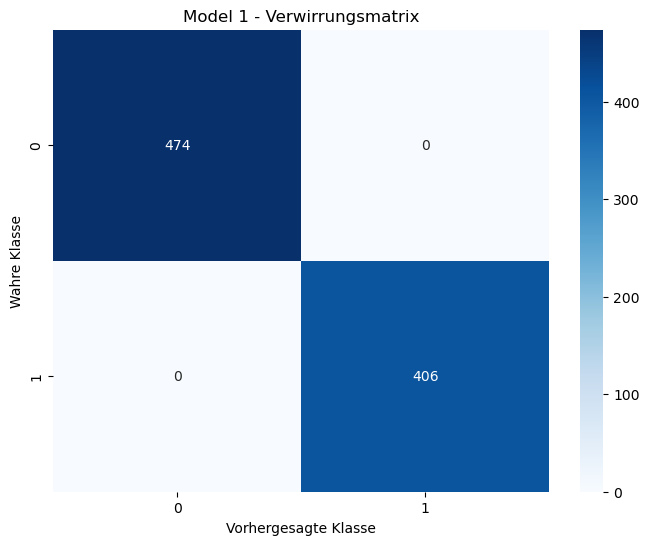

Model 1 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       474
         1.0       1.00      1.00      1.00       406

    accuracy                           1.00       880
   macro avg       1.00      1.00      1.00       880
weighted avg       1.00      1.00      1.00       880

28/28 [==============================] - 0s 6ms/step - loss: 4.8389e-23 - accuracy: 1.0000
Model 2 - Test Loss: 4.838878156879842e-23
Model 2 - Test Accuracy: 1.0
28/28 [==============================] - 0s 3ms/step


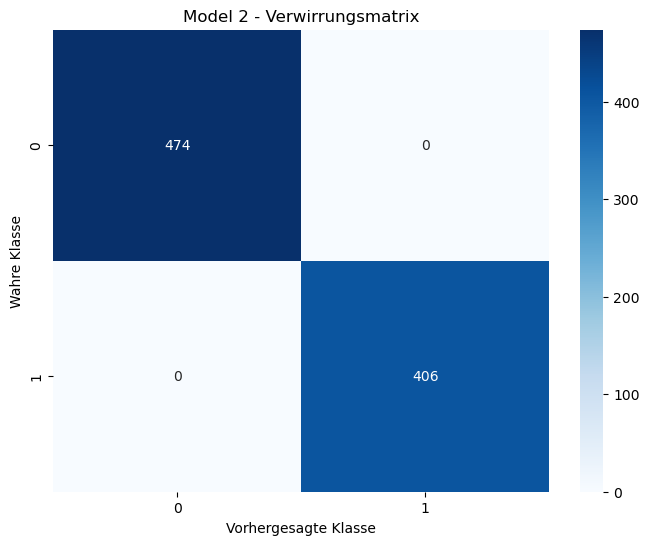

Model 2 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       474
         1.0       1.00      1.00      1.00       406

    accuracy                           1.00       880
   macro avg       1.00      1.00      1.00       880
weighted avg       1.00      1.00      1.00       880

28/28 [==============================] - 0s 8ms/step - loss: 3.1280e-24 - accuracy: 1.0000
Model 3 - Test Loss: 3.1279683844161046e-24
Model 3 - Test Accuracy: 1.0
28/28 [==============================] - 0s 5ms/step


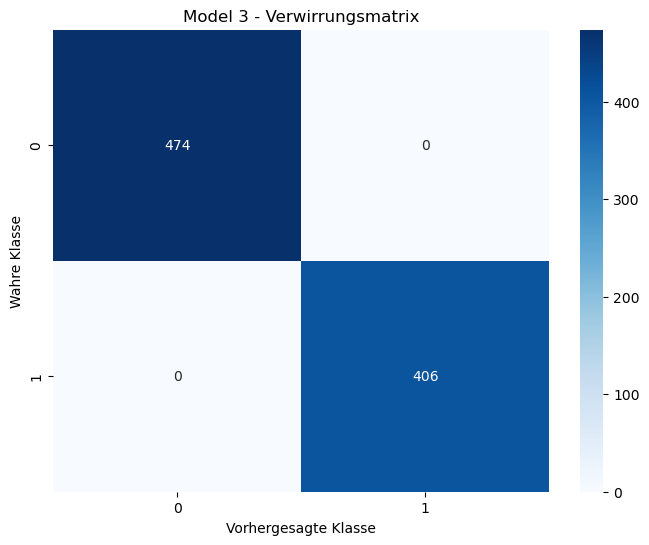

Model 3 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       474
         1.0       1.00      1.00      1.00       406

    accuracy                           1.00       880
   macro avg       1.00      1.00      1.00       880
weighted avg       1.00      1.00      1.00       880



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

for model, name in zip([model_1, model_2, model_3], ['Model 1', 'Model 2', 'Model 3']):
    # Modell bewerten
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"{name} - Test Loss: {loss}")
    print(f"{name} - Test Accuracy: {accuracy}")

    # Vorhersagen auf dem Testdatensatz
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")

    # Verwirrungsmatrix erstellen
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Verwirrungsmatrix')
    plt.xlabel('Vorhergesagte Klasse')
    plt.ylabel('Wahre Klasse')
    plt.show()

    # Klassifikationsbericht anzeigen
    print(f"{name} - Klassifikationsbericht")
    print(classification_report(y_test, y_pred_classes))


In [ ]:
import visualkeras

for model, name in zip(models, model_names):
    # Modellarchitektur visualisieren
    visualkeras.layered_view(model, to_file=f'{name}_architecture.png').show()
